In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!tar -xzvf gdrive/My\ Drive/data/lenses.tgz

In [3]:
!pip install -q datasets transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 77.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 56.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 105.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 13.1 MB/s eta 0:00:00


In [4]:
from datasets import load_dataset 

# load a custom dataset from local/remote files or folders using the ImageFolder feature
dataset = load_dataset("imagefolder", data_dir="/content/lenses")

Resolving data files:   0%|          | 0/10000 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-82b4f22661a5f1f9/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)
from transformers import AutoFeatureExtractor
model_checkpoint="microsoft/beit-base-patch16-224"
batch_size=32
feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)
normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)

height, width = feature_extractor.size["height"], feature_extractor.size["width"]

train_transforms = Compose(
        [
            RandomResizedCrop((height, width)),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize((height, width)),
            CenterCrop((height, width)),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch


/usr/local/lib/python3.9/dist-packages/transformers/models/beit/feature_extraction_beit.py:28: FutureWarning: The class BeitFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use BeitImageProcessor instead.
  warnings.warn(


In [6]:
# split up training into training + validation
splits = dataset["train"].train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

In [7]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

In [8]:
# train_ds[0]
print(len(val_ds))

1000


In [12]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

label2id

{'no_sub': 0, 'sub': 1}

In [13]:
from transformers import BeitForImageClassification, Trainer, TrainingArguments
model = BeitForImageClassification.from_pretrained(
    model_checkpoint, 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)


Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

<ipython-input-14-0b5c6e57190d>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [20]:
# Defining training arguments (set push_to_hub to false if you don't want to upload it to HuggingFace's model hub)
training_args = TrainingArguments(
    f"beit-finetuned-dark",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=10,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

# Instantiate the Trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=feature_extractor,
)

In [21]:
# Train and save results
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

# Evaluate on validation set
metrics = trainer.evaluate(val_ds)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

Epoch,Training Loss,Validation Loss,Accuracy
0,0.662400,0.648775,0.572000
2,0.703300,0.591316,0.642000
2,0.411600,0.413881,0.822000
4,0.476900,0.222022,0.907000
4,0.271100,0.310553,0.864000
6,0.280400,0.087216,0.974000
6,0.254700,0.180418,0.920000
8,0.248600,0.067741,0.971000
8,0.218200,0.069974,0.972000
9,0.156200,0.040966,0.982000


***** train metrics *****
  epoch                    =         9.93
  total_flos               = 6448089624GF
  train_loss               =       0.3834
  train_runtime            =   0:54:05.18
  train_samples_per_second =       27.733
  train_steps_per_second   =        0.216


***** eval metrics *****
  epoch                   =       9.93
  eval_accuracy           =      0.982
  eval_loss               =      0.041
  eval_runtime            = 0:00:13.01
  eval_samples_per_second =     76.828
  eval_steps_per_second   =      2.458


In [22]:
!cp -r /content/beit-finetuned-dark /content/gdrive/MyDrive/data

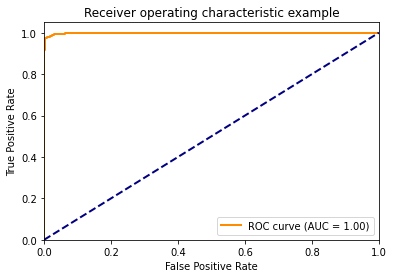

In [50]:
from sklearn.metrics import roc_curve, auc

val_labels = [val_ds[i]['label'] for i in range(len(val_ds))]
# Compute predicted probabilities on validation dataset
predictions = trainer.predict(val_ds)[0]
probs = predictions[:, 1]  # Probability of positive class

# Compute ROC curve and AUC score
fpr, tpr, _ = roc_curve(val_labels, probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
import matplotlib.pyplot as plt
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()